# Train model

In [1]:
from artefact_nca.dataset.voxel_dataset import VoxelDataset
from artefact_nca.model.voxel_ca_model import VoxelCAModel
from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer
from import_xml import read_vxa

/home/kazuyahoribe/.pyenv/versions/3.8.6/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
import numpy as np
mats= read_vxa('biped.vxa')
color_dict={0: '_empty', 1: 'aqua', 2: 'blue', 3: 'red', 4: 'green'}
mats = np.array(mats)
#print(mats.shape)
mats=mats.transpose(2,1,0)
#mats[0][0][0]

[[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1]], [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [3, 3, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1]], [[0, 3, 3, 3, 3, 3, 0], [0, 2, 3, 3, 3, 3, 0], [0, 2, 3, 1, 3, 3, 0], [0, 3, 3, 3, 1, 3, 0], [3, 3, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1]], [[0, 3, 3, 3, 3, 3, 0], [0, 1, 3, 3, 3, 3, 0], [0, 0, 3, 3, 3, 3, 0], [0, 3, 3, 3, 3, 3, 0], [3, 3, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3], [3, 1, 1, 1, 1, 1, 1]], [[0, 3, 3, 3, 3, 3, 0], [0, 3, 3, 3, 3, 3, 0], [0, 3, 3, 3, 3, 3, 0], [0, 3, 3, 3, 3, 3, 0], [0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3], [3, 1, 1, 1, 1, 1, 1]], [[3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3], [1, 3, 1, 1, 1, 1, 3]], [[3, 3, 3, 3, 3, 3, 3

## Plot original soft robot

/tmp/ipykernel_21218/1989331335.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


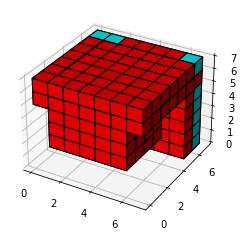

In [3]:
import matplotlib.pyplot as plt
x, y, z = np.indices((7, 7, 7))

colors = np.copy(mats)
colors = colors.astype('object')
#print(colors)

colors[colors==0] = None
colors[colors==1] = color_dict[1]
colors[colors==2] = color_dict[2]
colors[colors==3] = color_dict[3]
colors[colors==4] = color_dict[4]
#print(colors)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

In [4]:
import attr
import torch.nn.functional as F
import torch
from einops import rearrange

@attr.s
class CustomMSETrainer(VoxelCATrainer):

    def get_fitness(self, grown_robot):
        return 0
    
    def custom_seed(self, batch_size):
        depth = self.dataset.depth
        height = self.dataset.height
        width = self.dataset.width
        
        seed = np.ones(
                    (batch_size, depth, height, width, self.num_channels)
                ) * 10
        return torch.from_numpy(seed).float().to(self.device)
    
    def train_func(self, x, targets, steps=1):
        self.optimizer.zero_grad()
        x = self.model(x, steps=steps, rearrange_output=False)
        fitness = self.get_fitness(x)
    
        loss, iou_loss = self.get_loss(x, targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        x = rearrange(x, "b c d h w -> b d h w c")
        out = {
            "out": x,
            "metrics": {"loss": loss.item(), "iou_loss": iou_loss.item()},
            "loss": loss,
        }
        return out

    def train_iter(self, batch_size=32, iteration=0):
        batch, targets, indices = self.sample_batch(batch_size)
        batch = self.custom_seed(batch_size)
        if self.use_sample_pool:
            with torch.no_grad():
                loss_rank = (
                    self.rank_loss_function(batch, targets)
                    .detach()
                    .cpu()
                    .numpy()
                    .argsort()[::-1]
                )
                batch = batch[loss_rank.copy()]
                batch[:1] = torch.from_numpy(self.get_seed()).to(self.device)

                if self.damage:
                    self.apply_damage(batch)

        steps = np.random.randint(self.min_steps, self.max_steps)
        if self.half_precision:
            with torch.cuda.amp.autocast():
                out_dict = self.train_func(batch, targets, steps)
        else:
            out_dict = self.train_func(batch, targets, steps)
        out, loss, metrics = out_dict["out"], out_dict["loss"], out_dict["metrics"]

        if self.update_dataset and self.use_sample_pool:
            self.update_dataset_function(out, indices)
        out_dict["prev_batch"] = batch.detach().cpu().numpy()
        out_dict["post_batch"] = out.detach().cpu().numpy()
        return out_dict

In [5]:
ct = CustomMSETrainer.from_config(
                    "softrobot.yaml",
                    config={
                        "dataset_config":{"target_voxel":mats, "target_unique_val_dict":color_dict},
                        "use_cuda":False
                    }
                )

2022-01-06 21:52:04.383166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/root/.mujoco/mjpro150/bin
2022-01-06 21:52:04.383231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
ct.train()

Before --- After


loss:1.4552040100097656--iou_loss:0.6793103218078613:   0%|          | 0/20000 [00:09<?, ?it/s]


KeyboardInterrupt: 

## Save model

In [7]:
torch.save({"model":ct.model.state_dict()}, "biped_model.pt")

# Test model

## Load model

In [10]:
ct.load_model("biped_model.pt", load_optimizer_and_scheduler = False)

In [11]:
from IPython.display import clear_output
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

## Growth from single Cell

/tmp/ipykernel_21218/3053811286.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


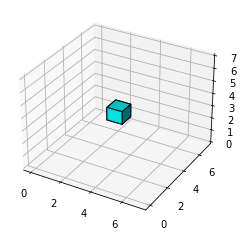

In [12]:
seed = np.random.rand(1, 7, 7, 7, ct.num_channels)

seed = torch.from_numpy(seed).float().to(ct.device)
'''
for i in range(7):
    for j in range(7):
        for k in range(7):
            seed[0][i][j][k][0] = mats[i][j][k]
'''
for i in range(7):
    for j in range(7):
        for k in range(7):
            seed[0][i][j][k][:] = 0
            
seed[0][3][3][3][0] = 1
seed[0][3][3][3][5] = 1
seed[0,:,:,:,0]

colors = np.copy(seed[0,:,:,:,0])
a =  np.copy(seed[0,:,:,:,0])
colors = colors.astype('object')
#print(colors)

colors[colors==0] = None
colors[colors==1] = color_dict[1]
colors[colors==2] = color_dict[2]
colors[colors==3] = color_dict[3]
colors[colors==4] = color_dict[4]
#print(colors)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

In [13]:
import argparse
import os

from base import Sim, Env
from read_write_voxelyze import write_voxelyze_file_vis

#a=a.transpose(2,0,1)
#a=a.transpose()
#a = np.fliplr(a)

input_dim = 3*9*2
num_classes = 5+1 #settings['voxel_types'] + 1
im_size = 9
iterations = 1
hidden_dim = 64

# Setting up the simulation object
sim = Sim(dt_frac= 0.9, simulation_time=0.55, fitness_eval_init_time=0.05)
# Setting up the environment object
env = Env(sticky_floor=0, time_between_traces=0)

write_voxelyze_file_vis(sim, env, 0 , 0, a, 0, im_size, 'biped_growth', 'zerostep')

/tmp/ipykernel_21218/1599383827.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


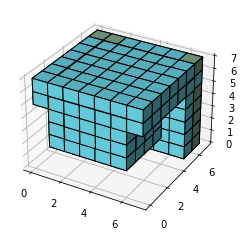

In [14]:
with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=60, initial=seed)
_ = visualize_output(ct, final.cpu().numpy())

In [15]:
arr = states
#np.save("left_regrown_100.npy", arr)
#arr.shape
#arr[99].shape
torch.save(arr,'biped_growth/input_arr.pt')
arr[0].shape
#final = arr[100][0,:,:,:,0:5]
voxcel_states=[]
for i in range(len(arr)):
    val, index = torch.max(arr[i][0,:,:,:,0:5],3)
    voxcel_states.append(index)
torch.save(voxcel_states,'biped_growth/growth_states.pt')

### Evaluate similarity (Growth)

In [16]:
growth = voxcel_states[60]
growth = growth.numpy()
growth = growth.transpose(2,0,1)
a= np.equal(growth,mats)
np.count_nonzero(a)
similarity = np.count_nonzero(a)/343
similarity

1.0

In [17]:
np.count_nonzero(a)

343

### Save voxel states during growth

In [18]:
input_dim = 3*9*2
num_classes = 5+1 #settings['voxel_types'] + 1
im_size = 9
iterations = len(arr)
hidden_dim = 64

# Setting up the simulation object
sim = Sim(dt_frac= 0.9, simulation_time=0.55, fitness_eval_init_time=0.05)
# Setting up the environment object
env = Env(sticky_floor=0, time_between_traces=0)
# TODO auto-select
#dev_states = np.load('run3_nr_pop_1000/bestofFiles/dev_states_gen_478_id_789.npy')
#print(states[0][1:im_size-1,1:im_size-1,1:im_size-1].shape)
for i in range(len(voxcel_states)):
    voxcel_states[i] = voxcel_states[i].numpy().transpose(2,0,1)
    voxcel_states[i] = voxcel_states[i].transpose(2,1,0)
for itr in range(0,iterations):
    #print(itr)
    write_voxelyze_file_vis(sim, env, itr , 0, voxcel_states[itr], 0, im_size, 'biped_growth', 'growth')

## Damage recovery from 

In [19]:
r = torch.load('biped_growth/input_arr.pt')
s = r[len(r)-1]

/tmp/ipykernel_21218/1599383827.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


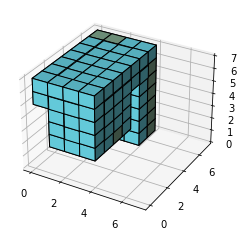

In [20]:
for i in range(7):
    for j in range(7):
        for k in range(4,7):
            s[0,i,j,k,:] = 0
for i in range(7):
    for j in range(7):
        for k in range(4,7):
            s[0,i,j,k,0] = 1
            s[0,i,j,k,5] = 1
t = visualize_output(ct, s.cpu().numpy())


In [21]:
t[0] = t[0].transpose(2,0,1)
#t[0] = t[0].transpose(2,1,0)

In [22]:
input_dim = 3*9*2
num_classes = 5+1 #settings['voxel_types'] + 1
im_size = 9
iterations = 1
hidden_dim = 64

dire = 'biped_left_damaged'
import os 
os.mkdir(dire)
# Setting up the simulation object
sim = Sim(dt_frac= 0.9, simulation_time=0.55, fitness_eval_init_time=0.05)
# Setting up the environment object
env = Env(sticky_floor=0, time_between_traces=0)

write_voxelyze_file_vis(sim, env, 0 , 0, t[0], 0, im_size, dire, 'zerostep')

/tmp/ipykernel_21218/1599383827.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


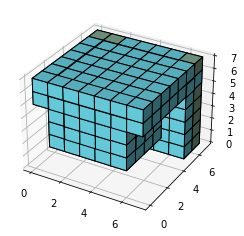

In [23]:
with torch.no_grad():
    final_regene, states_regene, life_masks_regene = ct.rollout(steps=180, initial=s)
_ = visualize_output(ct, final_regene.cpu().numpy())

### Save voxel states during regeneration

In [24]:
arr_regene = states_regene
#np.save("left_regrown_100.npy", arr)
#arr_regene.shape
#arr[99].shape
arr_regene[0].shape
#final = arr[100][0,:,:,:,0:5]
voxcel_states=[]
for i in range(len(arr_regene)):
    val_re, index_re = torch.max(arr_regene[i][0,:,:,:,0:5],3)
    voxcel_states.append(index_re)
torch.save(voxcel_states, dire + '/regene_states.pt')


### Evaluate Similarity (regeneration)

In [25]:
regene = voxcel_states[len(arr_regene)-1]
regene = regene.numpy()
regene = regene.transpose(2,0,1)
a= np.equal(regene,mats)
np.count_nonzero(a)
similarity = np.count_nonzero(a)/343
similarity

0.9970845481049563

In [26]:
np.count_nonzero(a)

342

In [27]:
import argparse
import os

from base import Sim, Env
from read_write_voxelyze import write_voxelyze_file_vis
input_dim = 3*9*2
num_classes = 5+1 #settings['voxel_types'] + 1
im_size = 9
iterations = len(arr_regene)
hidden_dim = 64

# Setting up the simulation object
sim = Sim(dt_frac= 0.9, simulation_time=0.55, fitness_eval_init_time=0.05)
# Setting up the environment object
env = Env(sticky_floor=0, time_between_traces=0)
# TODO auto-select
#dev_states = np.load('run3_nr_pop_1000/bestofFiles/dev_states_gen_478_id_789.npy')
#print(states[0][1:im_size-1,1:im_size-1,1:im_size-1].shape)
for i in range(len(voxcel_states)):
    voxcel_states[i] = voxcel_states[i].numpy().transpose(2,0,1)
    voxcel_states[i] = voxcel_states[i].transpose(2,1,0)
for itr in range(0,iterations):
    #print(itr)
    write_voxelyze_file_vis(sim, env, itr , 0, voxcel_states[itr], 0, im_size, dire, 'regene')